# Importing Libs

In [51]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
from sklearn.metrics import plot_precision_recall_curve, recall_score
from sklearn.pipeline import Pipeline
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('max_rows',50000)
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

[nltk_data] Downloading package stopwords to /Users/niall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/niall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Methods to be used 

In [2]:
def get_data():
    input_file = './Sarcasm_Headlines_Dataset.json'
    data = list(parseJson(input_file))

    df = pd.DataFrame(data)
    df = df[['is_sarcastic','headline']]
    df = shuffle(df)
    
    df['headline'] = df.headline.apply(to_lower)
    df['headline'] = df.headline.apply(punctuation_stp_words_lemmatize)
    tfidf_vectorizer = TfidfVectorizer(analyzer ='word', encoding= 'utf-8', decode_error = 'ignore', strip_accents='ascii')
    X = tfidf_vectorizer.fit_transform(df['headline'])
    X = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
    y = df['is_sarcastic']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test

In [34]:
table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer() 
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

def to_lower(inp):
    return inp.lower()

def punctuation_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def punctuation_stp_words_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [w for w in stripped if not w in stop_words]
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(min_df = 2,max_df = 1.0).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def roc_curve_plot(nb_probs):
    fpr, tpr, _ = roc_curve(y_test, nb_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
def print_auc_score(nb_probs):
    auc = roc_auc_score(y_test, nb_probs)
    print('AUC: ', auc)
    
def model_analysis(model, model_name, preds, nb_probs):
    average_precision = average_precision_score(y_test, preds)
    print(classification_report(y_test, preds))
    print()
    print(confusion_matrix(y_test, preds))
    print()
    print()
    print(model_name , ' accuracy score: ' , accuracy_score(y_test, preds))
    print(model_name , ' precision score: ' , precision_score(y_test, preds))
    print(model_name , ' recall score: ' , recall_score(y_test, preds))
    print(model_name , ' average precision-recall score: ' , average_precision)
    print()
    
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    

# Read data and split to training and test

In [4]:
sarcasm_headline_data = get_data()

In [5]:
X_train = sarcasm_headline_data[0]
X_test = sarcasm_headline_data[1]
y_train = sarcasm_headline_data[2]
y_test = sarcasm_headline_data[3]

In [6]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21464, 25860) (21464,)
(7155, 25860) (7155,)


# Train Four Ensemble Methods

In [10]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []

for name, model in ensembles:
    print(name)
    model.fit(X_train, y_train)
    Pkl_filename = name + "_model.pkl"
    
    with open(Pkl_filename, 'wb') as file:
        pickle.dump(model, file)

AB
GBM
RF
ET


In [11]:
AB_model = pickle.load( open( "AB_model.pkl", "rb"))
GBM_model = pickle.load( open( "GBM_model.pkl", "rb"))
RF_model = pickle.load( open( "RF_model.pkl", "rb"))
ET_model = pickle.load( open( "ET_model.pkl", "rb" ))

In [12]:
AB_predictions = AB_model.predict(X_test)
GBM_predictions = GBM_model.predict(X_test)
RF_predictions = RF_model.predict(X_test)
ET_predictions = ET_model.predict(X_test)

In [14]:
AB_nb_probs = AB_model.predict_proba(X_test)
AB_nb_probs = AB_nb_probs[:, 1]

GBM_nb_probs = GBM_model.predict_proba(X_test)
GBM_nb_probs = GBM_nb_probs[:, 1]

RF_nb_probs = RF_model.predict_proba(X_test)
RF_nb_probs = RF_nb_probs[:, 1]

ET_nb_probs = ET_model.predict_proba(X_test)
ET_nb_probs = ET_nb_probs[:, 1]

# Model Analysis

In [16]:
print('AB accuracy score' , accuracy_score(y_test, AB_predictions))
print('GBM accuracy score' , accuracy_score(y_test, GBM_predictions))
print('RF accuracy score' ,accuracy_score(y_test, RF_predictions))
print('ET accuracy score' , accuracy_score(y_test, ET_predictions))

AB accuracy score 0.6607966457023061
GBM accuracy score 0.6770090845562544
RF accuracy score 0.7720475192173305
ET accuracy score 0.7761006289308177


### AdaBoostClassifier

              precision    recall  f1-score   support

           0       0.62      0.92      0.74      3746
           1       0.81      0.38      0.52      3409

    accuracy                           0.66      7155
   macro avg       0.71      0.65      0.63      7155
weighted avg       0.71      0.66      0.63      7155


[[3434  312]
 [2115 1294]]


AB   accuracy score:  0.6607966457023061
AB   precision score:  0.8057285180572852
AB   recall score:  0.3795834555588149
AB   average precision-recall score:  0.6014386994031968



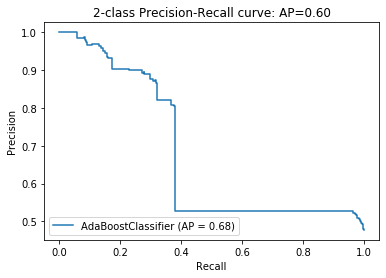

In [35]:
model_analysis(AB_model, 'AB ', AB_predictions, AB_nb_probs)

AUC:  0.7074883591485557


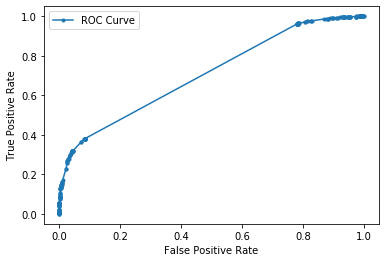

In [36]:
print_auc_score(AB_nb_probs)
roc_curve_plot(AB_nb_probs)

### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.63      0.95      0.75      3746
           1       0.87      0.38      0.53      3409

    accuracy                           0.68      7155
   macro avg       0.75      0.66      0.64      7155
weighted avg       0.74      0.68      0.65      7155


[[3553  193]
 [2118 1291]]


GBM   accuracy score:  0.6770090845562544
GBM   precision score:  0.8699460916442049
GBM   recall score:  0.37870343209152246
GBM   average precision-recall score:  0.6254683421287361



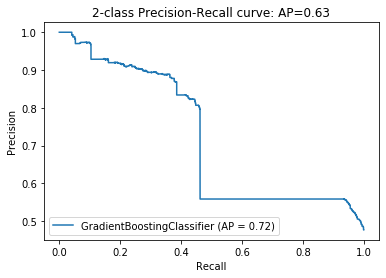

In [39]:
model_analysis(GBM_model, 'GBM ', GBM_predictions, GBM_nb_probs)

AUC:  0.7502858236034542


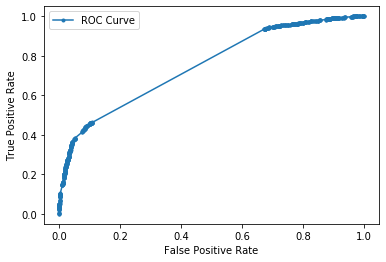

In [40]:
print_auc_score(GBM_nb_probs)
roc_curve_plot(GBM_nb_probs)

### RandomForestClassifier

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      3746
           1       0.81      0.68      0.74      3409

    accuracy                           0.77      7155
   macro avg       0.78      0.77      0.77      7155
weighted avg       0.78      0.77      0.77      7155


[[3201  545]
 [1086 2323]]


RF   accuracy score:  0.7720475192173305
RF   precision score:  0.8099721059972106
RF   recall score:  0.681431504840129
RF   average precision-recall score:  0.7037224817181029



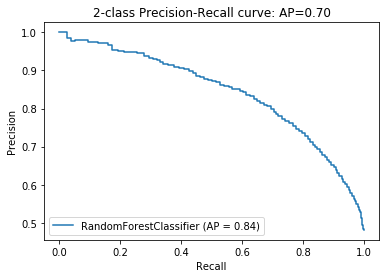

In [41]:
model_analysis(RF_model, 'RF ', RF_predictions, RF_nb_probs)

AUC:  0.854005375363133


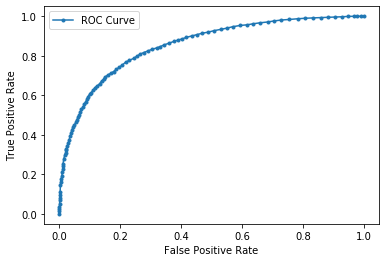

In [42]:
print_auc_score(RF_nb_probs)
roc_curve_plot(RF_nb_probs)

### ExtraTreesClassifier

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      3746
           1       0.82      0.68      0.74      3409

    accuracy                           0.78      7155
   macro avg       0.78      0.77      0.77      7155
weighted avg       0.78      0.78      0.77      7155


[[3240  506]
 [1096 2313]]


ET   accuracy score:  0.7761006289308177
ET   precision score:  0.8205037247250798
ET   recall score:  0.6784980932824876
ET   average precision-recall score:  0.7098898074461744



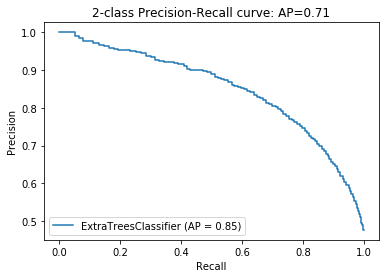

In [43]:
model_analysis(ET_model, 'ET ', ET_predictions, ET_nb_probs)

AUC:  0.8577697896823787


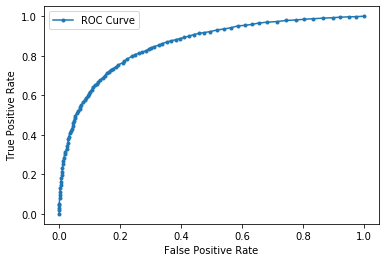

In [44]:
print_auc_score(ET_nb_probs)
roc_curve_plot(ET_nb_probs)

# Fine Tuning RandomForestClassifier

In [56]:
n_estimators = [10,30,50,100]
max_features = ["auto","log2"]
param_grid = dict(n_estimators=n_estimators,max_features=max_features )

model = RandomForestClassifier()
RF_new = RandomizedSearchCV(model, param_distributions=param_grid, cv=2, n_jobs=-1 ,verbose=10)
best_RF = RF_new.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 22.5min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 28.4min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 30.4min finished


In [64]:
print("Best: %f using %s" % (best_RF.best_score_, best_RF.best_params_))
means = best_RF.cv_results_['mean_test_score']
stds = best_RF.cv_results_['std_test_score']
params = best_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.760529 using {'n_estimators': 100, 'max_features': 'log2'}
0.720183 (0.004193) with: {'n_estimators': 10, 'max_features': 'auto'}
0.736908 (0.008899) with: {'n_estimators': 30, 'max_features': 'auto'}
0.741101 (0.010296) with: {'n_estimators': 50, 'max_features': 'auto'}
0.745527 (0.005404) with: {'n_estimators': 100, 'max_features': 'auto'}
0.710492 (0.003261) with: {'n_estimators': 10, 'max_features': 'log2'}
0.745527 (0.000559) with: {'n_estimators': 30, 'max_features': 'log2'}
0.757780 (0.004333) with: {'n_estimators': 50, 'max_features': 'log2'}
0.760529 (0.003634) with: {'n_estimators': 100, 'max_features': 'log2'}


In [58]:
best_RF_predictions = best_RF.predict(X_test)
best_RF_nb_probs = best_RF.predict_proba(X_test)
best_RF_nb_probs = best_RF_nb_probs[:, 1]

In [59]:
print('RF accuracy score' , accuracy_score(y_test, best_RF_predictions))

RF accuracy score 0.7893780573025856


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      3746
           1       0.86      0.67      0.75      3409

    accuracy                           0.79      7155
   macro avg       0.80      0.78      0.78      7155
weighted avg       0.80      0.79      0.79      7155


[[3362  384]
 [1123 2286]]


Best_RF   accuracy score:  0.7893780573025856
Best_RF   precision score:  0.8561797752808988
Best_RF   recall score:  0.6705778820768554
Best_RF   average precision-recall score:  0.7310883999795922



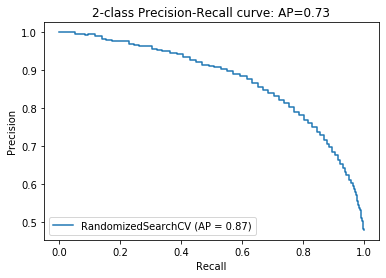

In [61]:
model_analysis(best_RF, 'Best_RF ', best_RF_predictions, best_RF_nb_probs)

AUC:  0.8811124160677031


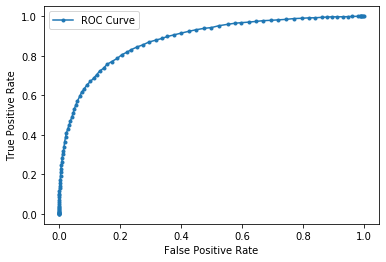

In [62]:
print_auc_score(best_RF_nb_probs)
roc_curve_plot(best_RF_nb_probs)